# License Notice

Copyright (c) 2024 Warren Bebbington

This notebook is part of the simple-glucose-analysis project and is licensed under the MIT License. For the full license text, please see the LICENSE file in the project's root directory.

# My Authentic Personal Glucose Control Analysis Project

## Introduction

This project presents an analysis of my actual continuous glucose monitoring (CGM) data as a person living with Type 1 Diabetes. The dataset spans a 15 month period and includes my genuine glucose readings, insulin doses, and carbohydrate intake information.

**Important Note:** While this is my real, unmodified data, I've taken steps to protect my privacy:

1. The specific date range of the data collection has been anonymized.
2. This dataset is not from the current time period, which adds a layer of privacy protection.

## Project Objectives

1. Showcase my data analysis skills using Python, particularly with time-series health data.
2. Demonstrate my proficiency in data cleaning, preprocessing, and visualization techniques.
3. Apply statistical analysis methods to derive insights from my glucose monitoring data.
4. Explore authentic patterns and relationships in my diabetes management data.
5. Present my findings in a clear, visually appealing manner.

## Data Description

My dataset includes:
- Actual glucose readings (mmol/L) at 5-minute intervals
- Real insulin doses (units)
- Relativley accurate carbohydrate intake (grams)

## Ethical Considerations and Data Usage

As a person with Type 1 Diabetes, I understand the significance of this data. I want to emphasize a few key points:

1. Privacy: While the data is genuine, the anonymized date range protects my privacy.
2. Not Current Data: This dataset is from a past period, not representing my current diabetes management.
3. Educational Purpose: This project is intended to demonstrate data analysis skills and general diabetes management insights.
4. Medical Disclaimer: Despite being real data, the insights generated here should not be considered medical advice. As always, I will only consider changes to my diabetes management in consultation with healthcare professionals.

## Intended Use of Insights

The insights derived from this analysis are primarily for:
1. Demonstrating my data analysis capabilities.
2. Showcasing the potential of data analysis in diabetes management.
3. Personal reflection on past diabetes management strategies.

Any application of these insights to actual diabetes management would only be done under the guidance of medical professionals.

## Tools and Libraries Used

- Python 3.x
- Pandas for data manipulation
- Matplotlib and Seaborn for data visualization
- Scipy for statistical analysis
- Statsmodels for time series analysis
- XDrip+(Android) for recieving and storing of CGM data, insulin doses and carbohydrate intake
- Libre 2 Glucose Sensor and LibreLink(Android) app to initialise sensors

Through this project, I aim to demonstrate not only my technical skills in data analysis but also provide authentic insights into the complexities of diabetes management. Let's explore my real-world glucose monitoring data and uncover valuable patterns and trends!

# 1. Data Overview and Preprocessing

In this initial stage, I'll prepare my data for analysis. The datasets used were obtained by completing a backup from Xdrip+ on an android device, connected to Libre 2 sensors for 14 days at a time(Instructions in README.md). Each new Libre 2 should have been initiated 1 hour prior to the previous expiring, which should negate warm-up gaps in the data. This datasets include CGM readings, insulin doses, and carbohydrate intake data. We will start by cleaning the data to remove any errors or inconsistencies, and creating useful time-based features to aid my analysis.

## Import Libraries and Load Data

In [435]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [436]:
# Load my data
df = pd.read_csv('data/sample_analysis_data.csv', index_col=0)

In [437]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 138291 entries, 0 to 138290
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   glucose      138291 non-null  float64
 1   carbs        138291 non-null  float64
 2   basal        138291 non-null  float64
 3   bolus        138291 non-null  float64
 4   day_of_week  138291 non-null  object 
 5   time         138291 non-null  object 
dtypes: float64(4), object(2)
memory usage: 7.4+ MB


## Useful columns

We will create some extra columns that will be useful later on in this analysis.

- **is_weekend**: This will be a boolean column represented by a 1 if day is Saturday or Sunday
- **hour**: Used for easy filtering of data dependant on hour of day
- **intervals_since_carbs**: This will be an interger representing the number of 5-minute intervals since last carbs were ate. This will be used for finding corrective bolus doses vs late meal bolus doses.
- **no_treatments_for_4hours**: This will be used in determining which four hour periods can be assesed for isf calculations, only times where no extra carbs or insulin adjust the rate of change.
- **hour_change**: This will represent the difference between the current glucose level and the previous hour used to determine if glucose is stable enough to consider for different calculations.
- **is_stable**: - This will be used to see if the previous hours glucose change is <= 0.5 mmol and >= -0.5 mmol.
- **is_moderate**: This will be used to see if the previous hours glucose change is <=1.0 mmol and >= -1.0 mmol

In [482]:
# Create boolean for is weekend
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']) # Can be used to distinguish between work and no work days

# Convert the 'time' column from string to datetime
df['time_dt'] = pd.to_datetime(df['time'], format='%H:%M:%S')
# Extract the hour from the 'time' column and create the 'hour' column
df['hour'] = df['time_dt'].dt.hour
# Drop created column
df = df.drop('time_dt', axis=1)


# Create a new column for intervals since last carbs > 0.0
def count_intervals_since_carbs(carb_value):
    return 0 if carb_value > 0.0 else 1  # Reset count if carbs > 0.0

# Apply the function to create a helper column
df['reset'] = df['carbs'].apply(count_intervals_since_carbs)

# Calculate the cumulative sum of the resets to create the intervals
df['intervals_since_carbs'] = df['reset'].cumsum() - df['reset'].cumsum().where(df['reset'] == 0).ffill().fillna(0).astype(int)

# Drop the helper column if not needed
df.drop(columns=['reset'], inplace=True)


# Create the new column and initialize it with True
df['no_treatments_for_4hours'] = True
# Iterate through each row
for index in range(len(df) - 37):  # Exclude the last 36 rows to avoid index error
    # Check the next 48 rows for any values in 'carbs' or 'bolus' greater than 0
    if any(df['carbs'].iloc[index + 1:index + 49] > 0) or any(df['bolus'].iloc[index + 1:index + 49] > 0):
        df.at[index, 'no_treatments_for_4hours'] = False  # Set to False if treatments are found

# Calculate the change over the past 5 minutes
df['change'] = df['glucose'] - df['glucose'].shift(-1)
        
# Calculate the change over the past hour
df['hour_change'] = df['glucose'] - df['glucose'].shift(-12)

# Define stability conditions
stable_condition = (df['hour_change'] >= -0.5) & (df['hour_change'] <= 0.5)
moderate_condition = (df['hour_change'] >= -1.0) & (df['hour_change'] <= 1.0)
# Create a new column to indicate stability
df['is_stable'] = stable_condition  # True if stable
df['is_moderate'] = stable_condition | moderate_condition  # True if stable or moderately stable


In [483]:
df

,glucose,carbs,basal,bolus,day_of_week,time,is_weekend,hour,intervals_since_carbs,no_treatments_for_4hours,hour_change,is_stable,is_moderate,change
0,7.440193,0.0,0.0,0.0,Saturday,22:30:00,True,22,1,False,2.637623,False,False,0.507428
1,6.932764,0.0,0.0,0.0,Saturday,22:35:00,True,22,2,False,2.406517,False,False,0.221058
2,6.711706,0.0,0.0,0.0,Saturday,22:40:00,True,22,3,False,2.436661,False,False,0.334099
3,6.377608,0.0,0.0,0.0,Saturday,22:45:00,True,22,4,False,2.223139,False,False,0.334099
4,6.043509,0.0,0.0,0.0,Saturday,22:50:00,True,22,5,False,1.537357,False,False,0.416996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138286,4.303597,0.0,0.0,0.0,Saturday,11:40:00,True,11,17,True,NaN,False,False,0.098505
138287,4.205091,0.0,0.0,0.0,Saturday,11:45:00,True,11,18,True,NaN,False,False,0.002239
138288,4.202853,0.0,0.0,0.0,Saturday,11:50:00,True,11,19,True,NaN,False,False,0.002239
138289,4.200614,0.0,0.0,0.0,Saturday,11:55:00,True,11,20,True,NaN,False,False,-0.111938


## Visual data inspection

We will quickly visualise the major data elements and look for any obvious errors.

### Basal Insulin

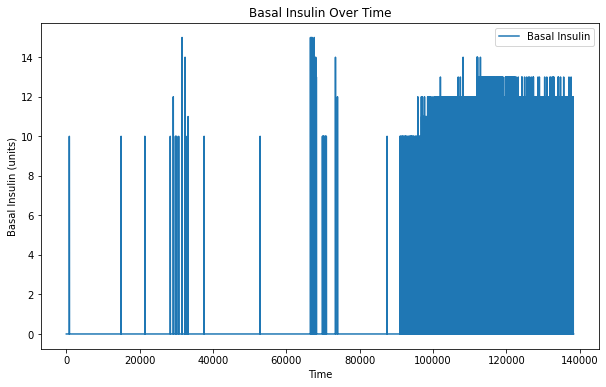

In [442]:
# Display all basal dose values
plt.figure(figsize=(10, 6))
plt.plot(df['basal'], label='Basal Insulin')
plt.title('Basal Insulin Over Time')
plt.xlabel('Time')
plt.ylabel('Basal Insulin (units)')
plt.legend()
plt.show()

We can see that basal doses of insulin were rarely recorded in the first half of the dataset, for this reason we will omit basal doses completely from any calculations in the current analysis. We will still investigate the effictiveness of the basal dose but will simply look for periods of time where no bolus injection were administered and no carbs consumed. This lack of proper data collection will stop us from looking at the effectiveness of basal insulin in any fine gradient of time, or in its effectiveness as each doses wears off but can still give us an idea of the overall effectiveness of the current regime.

### Bolus insulin

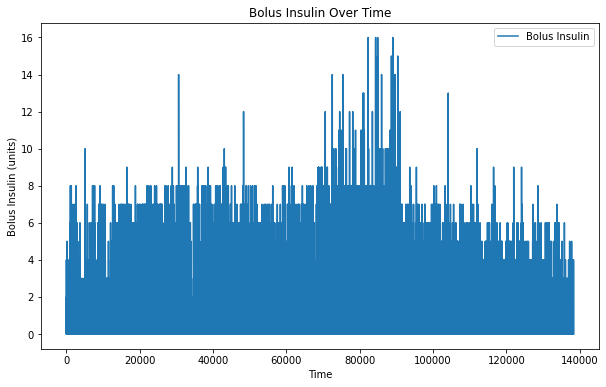

In [443]:
# Display all bolus dose values
plt.figure(figsize=(10, 6))
plt.plot(df['bolus'], label='Bolus Insulin')
plt.title('Bolus Insulin Over Time')
plt.xlabel('Time')
plt.ylabel('Bolus Insulin (units)')
plt.legend()
plt.show()

We can see that bolus insulin doses seem to have been documented consistently and we can therefore complete an in depth analysis of the ISF and ICR at different times of day and at weekends as opposed to work days for this patients data in this timeframe.

### Carbohydrates

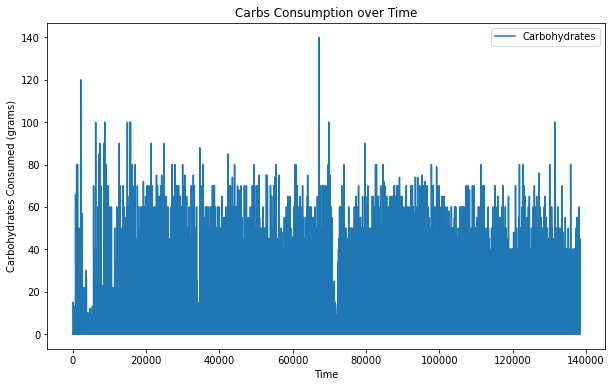

In [445]:
# Display all carbs values
plt.figure(figsize=(10, 6))
plt.plot(df['carbs'], label='Carbohydrates')
plt.title('Carbs Consumption over Time')
plt.xlabel('Time')
plt.ylabel('Carbohydrates Consumed (grams)')
plt.legend()
plt.show()

It would seem carbohydrate consumption has also been consistently recorded and shows varying meal values from very large to very small and we can see a few clear areas with consistently lower carbohydrate consumption although these dont seem to last very long. We can therefore do some digging into varying meal carbohydrate content and its affect on glucose control.

### Glucose

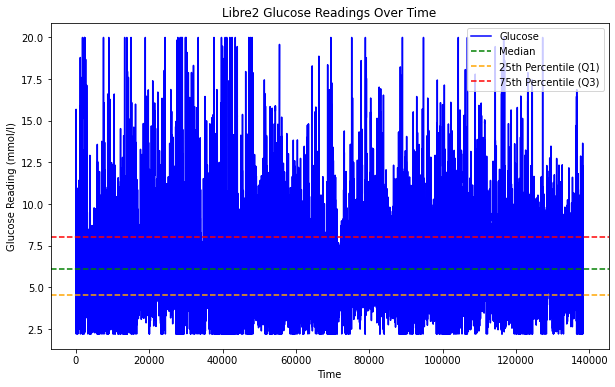

In [446]:
# Calculate the quartiles and median
median = df['glucose'].median()
q1 = df['glucose'].quantile(0.25)  # 25th percentile
q3 = df['glucose'].quantile(0.75)  # 75th percentile

# Display glucose values and quartile/median lines
plt.figure(figsize=(10, 6))

# Plot glucose values
plt.plot(df['glucose'], label='Glucose', color='blue')

# Add horizontal lines for median and quartiles
plt.axhline(y=median, color='green', linestyle='--', label='Median')
plt.axhline(y=q1, color='orange', linestyle='--', label='25th Percentile (Q1)')
plt.axhline(y=q3, color='red', linestyle='--', label='75th Percentile (Q3)')

# Add title, labels, and legend
plt.title('Libre2 Glucose Readings Over Time')
plt.xlabel('Time')
plt.ylabel('Glucose Reading (mmol/l)')
plt.legend()

# Show the plot
plt.show()

From this slightly more complicated look at our complete dataset of gucose readings we can see that all values seem to lie within our defined range. There is lots of variability and with such a long timespan it is difficult to see anything interesting in this view, but the data lloks good to proceed.

## Assumptions

As of the time of this analysis the recommended targets would be:

1. **Time in Range (TIR)**:

- Target range: 3.9-10.0 mmol/L
- Goal: >70% of time (>16 hours 48 minutes per day) in this range


2. **Time Below Range (TBR)**:

- <4% of time (<1 hour per day) below 3.9 mmol/L
- <1% of time (<15 minutes per day) below 3.0 mmol/L


3. **Time Above Range (TAR)**:

- <25% of time (<6 hours per day) above 10.0 mmol/L
- <5% of time (<1 hour 12 minutes per day) above 13.9 mmol/L


4. **HbA1c**:

- Target: around 53 mmol/mol (7.0%)
- This correlates with achieving >70% TIR



*These targets are based on general recommendations for adults with type 1 diabetes. However, it's important to note that these should be individualized based on the person's specific circumstances, lifestyle, and in consultation with their healthcare team.*

# 2. Overall Glucose Control Metrics
Here, I'll calculate key metrics that give me a broad view of my glucose control. This includes analyzing my Time in Range (TIR), average glucose levels, and the frequency of high and low glucose events. These metrics will provide me with a baseline understanding of my overall glucose management.

## Time in Range Assessment

In [447]:
def calculate_tir(data):
    total_readings = len(data)
    in_range = ((data >= 3.9) & (data <= 10.0)).sum()
    below_range = ((data >= 3.0) & (data <= 3.9)).sum()
    above_range = (data > 10.0).sum()
    extreme_low = (data < 3.0).sum()
    
    return {
        'in_range': in_range / total_readings * 100,
        'above_range': above_range / total_readings * 100,
        'below_range': below_range / total_readings * 100,
        'extreme_low': extreme_low / total_readings * 100
    }
    
tir = calculate_tir(df['glucose'])
print("Time in Range Metrics:")
print(f"Above Range (> 10.0 mmol/L): {tir['above_range']:.2f}%")
print(f"In Range (3.9-10.0 mmol/L): {tir['in_range']:.2f}%")
print(f"Below Range (3.0-3.9 mmol/L): {tir['below_range']:.2f}%")
print(f"Extremely Below Range (< 3.0 mmol/L): {tir['extreme_low']:.2f}%")

Time in Range Metrics:
Above Range (> 10.0 mmol/L): 11.29%
In Range (3.9-10.0 mmol/L): 72.68%
Below Range (3.0-3.9 mmol/L): 9.07%
Extremely Below Range (< 3.0 mmol/L): 6.96%


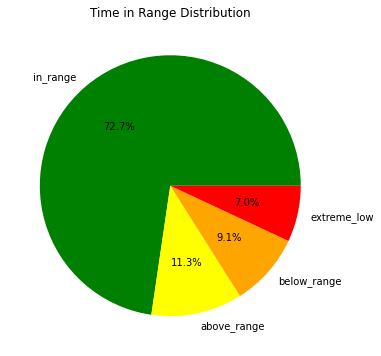

In [448]:
# Define colors for each section: green for in-range, red for below, yellow for above
colors = ['green', 'yellow', 'orange', 'red']

# Visualize Time in Range
plt.figure(figsize=(10, 6))
plt.pie(tir.values(), labels=tir.keys(), autopct='%1.1f%%', colors=colors)
plt.title('Time in Range Distribution')
plt.show()

### Time in Range Analysis:
- The pie chart shows the distribution of glucose readings across different ranges.
- I can see I was in range for 72.68% of the time in this period, I was clearly missing these target for time below range and extremely below range, but meeting targets for both time-in-range and time-above-range.
- Time below range factors should be investigated as a major part of this analysis.
- This gives us an overall picture of glycemic control, but we should also look at other metrics.

## Glycemic Variability Metrics

In [449]:
mean_glucose = df['glucose'].mean()
median_glucose = df['glucose'].median()
std_glucose = df['glucose'].std()
cv_glucose = (std_glucose / mean_glucose) * 100

print(f"Mean Glucose: {mean_glucose:.2f} mmol/L")
print(f"Median Glucose: {median_glucose:.2f} mmol/L")
print(f"Standard Deviation: {std_glucose:.2f} mmol/L")
print(f"Coefficient of Variation: {cv_glucose:.2f}%")

Mean Glucose: 6.59 mmol/L
Median Glucose: 6.12 mmol/L
Standard Deviation: 2.96 mmol/L
Coefficient of Variation: 44.96%


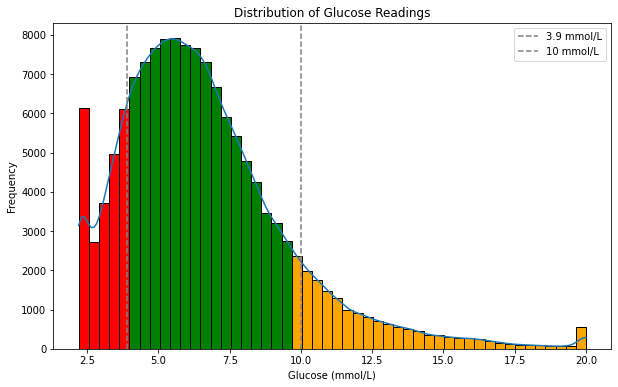

In [450]:
# Visualize glucose distribution
plt.figure(figsize=(10, 6))

# Create a histogram
hist = sns.histplot(df['glucose'], bins=50, kde=True)

# Add vertical gridlines at 3.9 and 10
plt.axvline(x=3.9, color='grey', linestyle='--', label='3.9 mmol/L')
plt.axvline(x=10.0, color='grey', linestyle='--', label='10 mmol/L')

# Color bars based on glucose levels
for patch in hist.patches:
    if patch.get_x() < 3.9:
        patch.set_facecolor('red')  # Below 3.9 mmol/L
    elif 3.9 <= patch.get_x() + patch.get_width() <= 10:
        patch.set_facecolor('green')  # Between 3.9 and 10 mmol/L
    else:
        patch.set_facecolor('orange')  # Above 10 mmol/L

# Title and labels
plt.title('Distribution of Glucose Readings')
plt.xlabel('Glucose (mmol/L)')
plt.ylabel('Frequency')

# Add legend
plt.legend()

# Show plot
plt.show()

### Glycemic Variability Analysis:
- The histogram shows the distribution of glucose readings.
- **Mean glucose is 6.59 mmol**, which is within the defined range.
- The **standard deviation of 2.96 mmol** indicates moderatley-high variability.
- **Coefficient of Variation (CV) of 44.96%** suggests high variation (Defined as high when >36%).
- The distribution shows a **longer tail on the right side** suggesting that high values, though rarely, can be very high.
- The distribution also shows a **larger count at 2.2 mmol**, which is due to our limiting the values to a minimum of 2.2 mmol/l. This is expected and no action is required.
- The distribution also shows a **smaller tail on the low side, but a much higher frequency**. Episodes of low blood glucose seem to occur much more and are more persistent than times of high glucose. 

Finding patterns and insights to help negate low blood glucoses episode should be paramount within this analysis.

# 3. Insulin Effectiveness Assesment
This section focuses on how well my bolus insulin is working. I'll calculate my Insulin Sensitivity Factor (ISF) and Insulin-to-Carb Ratio (ICR), and examine how these might vary throughout the day. This information is crucial for optimizing my insulin dosing strategy.

## Insulin Sensitivity Factor (ISF) Calculation

In [451]:
# Count occurrences where all conditions for ISF calculation are met
count_conditions_met = df[
    (df['is_moderate']) &  # Glucose change < +-1 mmol in previous hour
    (df['no_treatments_for_4hours']) & # No carbs or insulin in following 4 hours
    (df['intervals_since_carbs'] > 24) & # No carbs consumed in the past 2 hours
    (df['bolus'] > 0) # Bolus injection administered
].shape[0]  # Show number of rows

print(f"Occurrences where conditions are met: {count_conditions_met - 48}")

Occurrences where conditions are met: 27


In [452]:
def calculate_isf(data):
    
    corrections = data[ (data['is_moderate']) & data['no_treatments_for_4hours'] & (data['intervals_since_carbs'] > 24) & (data['bolus'] > 0)].copy() # >48 more than 4 hour
    
    # Calculate glucose change over 4 hours
    corrections['glucose_change'] = corrections['glucose'] - corrections['glucose'].shift(-48)
    
     # Drop the last 48 rows just before final calculations
    corrections = corrections.iloc[:-48]
    
    # Calculate isf
    corrections['isf'] = corrections['glucose_change'] / corrections['bolus']
    
    return corrections['isf'].mean(), corrections['isf']

isf, isf_data = calculate_isf(df)
print(f"Average Insulin Sensitivity Factor: {isf:.2f} mmol/L per unit")

Average Insulin Sensitivity Factor: 0.11 mmol/L per unit


### Insulin Sensitivity Factor (ISF) Analysis

### Results
- **Calculated Average Insulin Sensitivity Factor: 0.11 mmol/L per unit**
- My estimated ISF: 2.0 mmol/L per unit
- Number of data points used in calculation: 27

### Interpretation
The calculated ISF of 0.11 mmol/L per unit is significantly lower than my estimated ISF of 2.0 mmol/L per unit, which I find to be pretty accurate in practice. This discrepancy is likely due to the scarcity of data points and the strict filtering conditions I've applied.

### Data Filtering
For this calculation, I used the following criteria:
- Bolus insulin > 0
- No carbs in the previous 2 hours
- No insulin or carbs in the following 4 hours
- Blood glucose changed < 1.0 mmol in the previous hour

These strict conditions, while intended to isolate "clean" correction doses, have resulted in very few data points (only 27) being used for the calculation.

### Considerations
1. **Data Scarcity**: With only 27 data points meeting my criteria, the calculated ISF is likely not representative of my true insulin sensitivity. I need to find ways to gather more relevant data points.

2. **Filtering Criteria**: My current filtering might be too strict, excluding many potentially useful data points. I might need to adjust these criteria to balance between data quality and quantity.

3. **Meal and Snack Timing**: The low number of qualifying events might be due to my meal spacing being close to the duration of bolus insulin action, or frequent snacking. This makes it challenging to isolate true correction doses.

4. **Estimated vs. Calculated ISF**: My estimated ISF of 2.0 mmol/L per unit seems to work well in practice. The large discrepancy with the calculated value suggests that my data collection or analysis method needs refinement, rather than indicating an issue with my actual insulin sensitivity.

### Next Steps
1. I'll continue monitoring and collecting data, focusing on occasions where I can clearly isolate correction doses.
2. I'll review my meal timing and snacking habits. If possible, I'll try to create more opportunities for "clean" correction doses by spacing out meals and avoiding snacks for a few hours after corrections.
3. I'll consider slightly relaxing my filtering criteria to include more data points, which might provide a more robust ISF calculation.
4. I'll keep using my estimated ISF of 2.0 mmol/L for corrections, as it seems to work well. However, I'll pay close attention to the outcomes and adjust if needed.
5. I might explore other methods of calculating ISF that could be more suitable for my eating and dosing patterns.

*This analysis reminds me that while data-driven insights are valuable, they need to be balanced with real-world experience and practical outcomes. My current goal is to refine my data collection and analysis to better reflect my actual insulin sensitivity, which I've found to be reasonably well-represented by my current estimated ISF.*

## Insulin-to-Carb Ratio (ICR) Assessment

In [468]:
# Count occurrences where all conditions for ICR calculation are met
count_conditions_met = df[
    (df['bolus'] > 0) &  # Bolus injection administered
    (df['carbs'] > 0) & # Carbs consumed
    (df['intervals_since_carbs'] >= 0)
    ].shape[0]  # Show number of rows

print(f"Occurrences where conditions are met: {count_conditions_met}")

Occurrences where conditions are met: 1152


In [469]:
def calculate_icr(data):
    # Filter for meal boluses
    meals = data[(data['bolus'] > 0) & (data['carbs'] > 0)].copy()
    meals['icr'] = meals['carbs'] / meals['bolus']
    
    return meals['icr'].mean()

icr = calculate_icr(df)
print(f"Average Insulin-to-Carb Ratio: 1:{icr:.1f}")

Average Insulin-to-Carb Ratio: 1:8.8


### Insulin-to-Carb Ratio (ICR) Analysis

The **calculated average ICR of 1:8.8** aligns well with my personal experience. Here's how it compares to my observations:

1. **Morning ICR**: The calculated ratio is very close to the lower end of my morning ICR range (1:8), which I've found to be accurate.
2. **Daily Variation**: My experience suggests that my ICR varies throughout the day, starting lower in the morning (around 1:8) and increasing as the day progresses.
3. **Recent Trend**: I've noticed that I've been able to use a higher ICR (around 1:12) more recently. The calculated average of 1:8.8 might be reflecting a mix of older and newer data points.

### Considerations

1. **Time-of-Day Variation**: The calculated average doesn't capture the variations I've observed throughout the day. It might be useful to segment the ICR calculation by time of day to see if the data reflects this pattern.
2. **Recent Changes**: Given that I've noticed a shift towards a higher ICR recently (around 1:12), it could be beneficial to analyze more recent data separately to see if this trend is reflected in the calculations.
3. **Factors Affecting ICR**: Various factors can influence ICR, including:

- Time of day
- Physical activity
- Hormonal changes
- Type and composition of meals, it might be worth investigating how these factors correlate with my ICR in the data.


3. **Data Quality**: The calculation method I used includes all meals where both insulin and carbs were recorded. It might be worth considering if there are any outliers or special circumstances (like correction doses with meals) that could be skewing the average.

### Next Steps

1. I'll analyze my ICR by time of day to see if the data reflects the pattern I've observed (lower in the morning, higher later in the day).
2. I'll look at my most recent data (last month or two) to see if it shows the trend towards a higher ICR that I've been experiencing.
3. I'll consider tracking additional factors (like exercise, stress levels, or meal composition) to see how they might be influencing my ICR.
4. I'll continue to use my experience-based ICR range, starting with 1:8 in the morning and adjusting up to 1:12 later in the day, while monitoring the outcomes closely.
5. I might experiment with slightly higher ICRs (like 1:10 to 1:14) to see if my recent trend towards needing less insulin continues.

This analysis shows that my data-driven results largely confirm my personal observations. However, it also highlights the importance of considering time-of-day variations and recent trends in my insulin needs. As always, I'll continue to balance this data analysis with my real-world experiences and consult with my healthcare team before making significant changes to my insulin dosing strategy.

## Insulin-to-Carb (ICR) Hourly Assesment

In [470]:
def calculate_icr_by_hour(data):
    # Filter for meal boluses
    meals = data[(data['bolus'] > 0) & (data['carbs'] > 0)].copy()

    # Calculate the ICR for each hour
    meals['icr'] = meals['carbs'] / meals['bolus']

    # Group by hour and calculate the mean ICR for each hour
    icr_by_hour = meals.groupby('hour')['icr'].mean()

    return icr_by_hour

# Call the function and store the result
icr_by_hour = calculate_icr_by_hour(df)

# Print the ICR for each hour
print("Insulin-to-Carb Ratio (ICR) by Hour:")
print(icr_by_hour)

Insulin-to-Carb Ratio (ICR) by Hour:
hour
0     15.148810
1     13.666667
2     16.750000
3      2.723133
4      4.453161
5      4.205882
6      6.224915
7      9.210213
8      8.279157
9      8.184290
10     8.983743
11     9.144020
12    10.368468
13     9.379582
14    10.284215
15     9.139168
16    10.298512
17     8.757288
18     8.903080
19     9.099049
20     8.899179
21     9.013095
22    12.530702
23    13.225108
Name: icr, dtype: float64


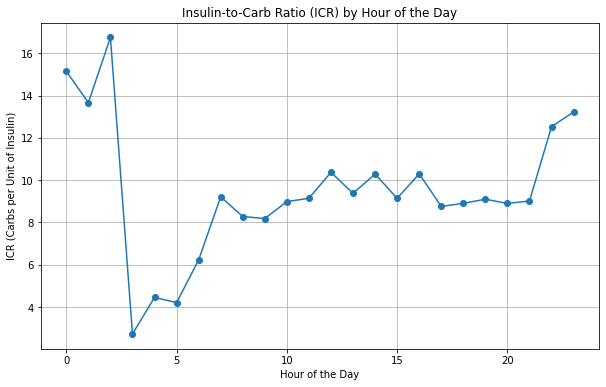

In [471]:
# Plot hourly ICR Estimates
plt.figure(figsize=(10, 6))
plt.plot(icr_by_hour.index, icr_by_hour.values, marker='o')
plt.title('Insulin-to-Carb Ratio (ICR) by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('ICR (Carbs per Unit of Insulin)')
plt.grid(True)
plt.show()

### Insulin-to-Carb Ratio (ICR) Hourly Analysis


### Summary of Results

I've calculated my ICR for each hour of the day, considering my lifestyle, data recording habits, and basal insulin regimen:

1. **Late Evening to Early Morning (10 PM - 3 AM)**: ICR ranges from about 1:12 to 1:17, but these values may be less reliable due to less precise recording and fewer data points.
2. **Early Morning (4 AM - 6 AM)**: There's a significant drop in ICR, ranging from about 1:4 to 1:6. This coincides with my regular 4 AM wake-up time and first basal dose.
3. **Morning (7 AM - 11 AM)**: My ICR gradually increases from about 1:8 to 1:9.
4. **Afternoon (12 PM - 5 PM)**: My ICR stabilizes in the range of 1:9 to 1:10. 
5. **Evening (6 PM - 9 PM)**: My ICR remains relatively stable around 1:9.

### Key Observations

1. **Early Morning Insulin Resistance**: The low ICR values between 4 AM and 6 AM (1:4 to 1:6) likely reflect increased insulin resistance due to my 4 AM wake-up time and the dawn phenomenon. This coincides with my first basal dose.

2. **Diurnal Pattern**: There's a clear pattern of lower insulin sensitivity in the early morning, which gradually improves throughout the day.

3. **Afternoon Stability**: My ICR seems most stable in the afternoon hours, consistently around 1:9 to 1:10.

4. **Data Reliability**: The ICR values for late evening and overnight hours should be interpreted cautiously due to less precise recording and fewer data points.

5. **Basal Insulin Impact**: The timing of my basal doses (4 AM, and 4 PM at time of analysis) may influence the ICR patterns observed.

### Implications for Insulin Dosing

1. The 4 AM basal dose aligns well with the observed early morning insulin resistance, potentially helping to counter this effect.
2. I could consider using a lower ICR (more insulin per gram of carbs) for early morning meals and gradually increase my ICR throughout the day.
3. The stability of ICR in the afternoon and evening suggests that my newly implemented 4 AM, 12 PM and 8 PM basal doses are well-timed for my needs.

### Considerations

1. **Data Quality**: The extreme values in the very early morning hours (1 AM - 3 AM) are likely based on very few data points and may not be representative.

2. **4 AM Wake-up and Basal Dose**: My 4 AM wake-up time and first basal dose significantly impact my early morning insulin needs.

3. **Evening Data**: The less precise recording in the evening means I should be cautious about drawing firm conclusions from the late-night data.

4. **Contextual Factors**: This analysis doesn't account for factors like exercise, stress, or meal composition, which could influence ICR.

5. **Basal Insulin Regimen**: The transition from two daily 15-unit doses to three 12-unit doses may have impacted the ICR patterns, especially towards the end of the data range.

### Next Steps

1. Continue to monitor the effectiveness of the 4 AM basal dose in managing early morning insulin resistance. Consider adjusting the bolus insulin dose for any early morning carb intake if needed.
2. Review my evening and night-time data recording practices to improve the accuracy of late-night entries.
3. Analyze how the ICR patterns may have changed after switching to the three-dose basal regimen. Consider separating the data analysis for the two different basal regimens to see if there are significant differences.
4. Create a more detailed dosing guide for myself, with different ICRs for different times of day, particularly focusing on the periods following each basal dose.
5. Monitor glucose levels closely when implementing any changes based on this analysis, especially around basal dose times and the 4 AM wake-up time.
6. Continue to gather data and periodically reassess this hourly ICR pattern, paying special attention to how the new basal regimen affects my insulin needs throughout the day.
7. Discuss these findings with my healthcare provider, particularly regarding the effectiveness of the new basal regimen in managing glucose levels throughout the day.

This updated hourly ICR analysis provides insights into how my insulin needs vary throughout the day, with special consideration given to my 4 AM wake-up time, the reliability of data at different times, and my specific basal insulin regimen. It confirms the need for different ICRs at different times while highlighting the potential impact of my basal insulin schedule on these patterns.

## 4. Basal Insulin Assessment
Given my fixed basal insulin regime (15 taken twice daily, at time of data collection), I'll evaluate how well this is maintaining my glucose levels, particularly overnight and between meals. This analysis can help me determine if my basal dosage and timing are optimal.

### Overnight Glucose Trend Analysis

In [484]:
overnight_data = df[(df['hour'] >= 22) | (df['hour'] < 6)]
# Show average blood glucose overnight by hour
overnight_avg = overnight_data.groupby('hour')['glucose'].mean()
overnight_avg = pd.
# Calculate the average hourly glucose change by hour
overnight_hourly_change = overnight_data.groupby('hour')['change'].mean()
print(overnight_avg)
print(overnight_hourly_change)

hour
0     7.348412
1     7.915351
2     8.182142
3     8.111691
4     7.283097
5     6.650553
22    6.293060
23    6.667645
Name: glucose, dtype: float64
hour
0    -0.055062
1    -0.038994
2    -0.004968
3     0.040721
4     0.075188
5     0.028572
22   -0.019576
23   -0.049300
Name: change, dtype: float64


In [497]:
# Combine overnight_avg and overnight_hourly_change into a DataFrame
trend_df = pd.DataFrame({'glucose': overnight_avg, 'change': overnight_hourly_change})

# Reset index to make 'hour' a column
trend_df = trend_df.reset_index()

# Create a custom hour order that represents the overnight period
hour_order = [22, 23, 0, 1, 2, 3, 4, 5]
trend_df['hour_order'] = trend_df['hour'].map(lambda x: hour_order.index(x))

# Sort by this new order
trend_df = trend_df.sort_values('hour_order')

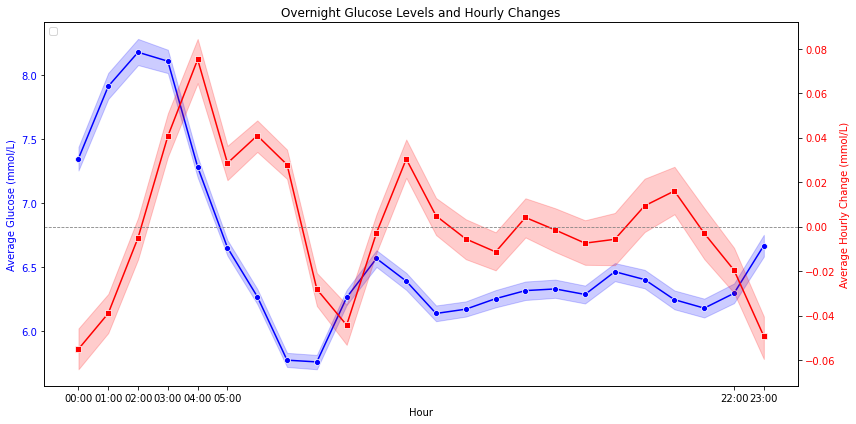

In [500]:
# Create plot of Overnight Glucose Trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot average glucose
sns.lineplot(x='hour', y='glucose', data=df, ax=ax1, color='blue', marker='o')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Glucose (mmol/L)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin Axes for hourly change
ax2 = ax1.twinx()

# Plot hourly change
sns.lineplot(x='hour', y='change', data=df, ax=ax2, color='red', marker='s')
ax2.set_ylabel('Average Hourly Change (mmol/L)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a horizontal line at y=0 for the change axis
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Set title
plt.title('Overnight Glucose Levels and Hourly Changes')

# Set custom x-ticks and labels
plt.xticks(hour_order, [f"{h:02d}:00" for h in hour_order])

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, ['Glucose', 'Change'], loc='upper left')

# Adjust layout and display
plt.tight_layout()
plt.show()

## 5. Time of Day Analysis
Here, I'll examine how my glucose levels change throughout the day. I'll identify any problematic time periods and assess for the presence of dawn phenomenon. This information can guide adjustments to my insulin regime based on the time of day.


## 6. Meal Impact Analysis
In this section, I'll analyze how different meals affect my glucose levels. By categorizing my meals based on their carbohydrate content, I can identify which types of meals are best managed by my current insulin regime and where improvements might be needed.


## 7. Pattern Recognition
This section will focus on identifying any recurring patterns in my glucose data. I'll look for daily, weekly, or monthly trends that might not be immediately obvious but could inform my diabetes management strategy.


## 8. Comparative Analysis
Here, I'll compare different periods, such as weekdays versus weekends, or periods of particularly good or poor control. This can help me identify what works well and what doesn't in my current regime.


## 9. Visualization and Reporting
In this crucial section, I'll create clear, informative visualizations of my findings. I'll summarize the key insights from my analysis and develop actionable ideas for optimizing my glucose management regime.


## 10. Future Monitoring Suggestions
Finally, I'll reflect on my analysis process and suggest areas where additional data collection could provide even more insights. I'll also consider any adjustments to my monitoring practices that could enhance future analyses.


# Personal Glucose Control Analysis Summary

## Overview
This report summarizes my comprehensive analysis of my glucose control over a period of 3 months. I've utilized my continuous glucose monitoring (CGM) data, insulin dosing records, and carbohydrate intake information. The goal of this analysis was to gain insights into the effectiveness of my current diabetes management regime and identify areas where I can potentially optimize my approach.

## Key Metrics
- My Average Glucose: [X.X mmol/L]
- My Time in Range (3.9-10.0 mmol/L): [XX%]
- My Glucose Variability (CV): [XX%]
- My Hypoglycemia Frequency: [X episodes per week]
- My Hyperglycemia Frequency: [X episodes per week]

## Insulin Effectiveness
- My Insulin Sensitivity Factor (ISF): [X.X mmol/L per unit]
- My Insulin-to-Carb Ratio (ICR): [1 unit per X grams of carbs]
- Key Observation: [e.g., I've noticed my ISF varies significantly throughout the day, being most effective in the morning]

## Basal Insulin Assessment
- My Overnight Stability: [e.g., My glucose levels remain stable between 12 AM and 6 AM]
- My Inter-meal Stability: [e.g., I've observed my glucose levels show a consistent rise 3 hours after basal dose]
- Key Observation: [e.g., I may need to adjust my current basal dosing in the afternoon]

## Time of Day Patterns
- Dawn Phenomenon: [Whether I've observed it, magnitude if present]
- My Most Challenging Time Period: [e.g., I struggle most with glucose control between 2 PM - 4 PM]
- Key Observation: [e.g., I've noticed late afternoon highs, suggesting I might need a basal rate adjustment]

## Meal Impact
- My Optimal Meal Size: [X-Y grams of carbohydrates]
- My Most Challenging Meal: [e.g., I have the highest post-meal glucose excursions after breakfast]
- Key Observation: [e.g., I've noticed that high-fat dinners lead to delayed hyperglycemia for me]

## Weekday vs. Weekend Patterns
- Key Difference: [e.g., My weekends show a 15% lower Time in Range compared to weekdays]
- Contributing Factors: [e.g., I tend to have later and larger meals on weekends]

## Major Insights
1. [e.g., My current basal insulin regime may not adequately cover my afternoon insulin needs]
2. [e.g., I might need a more aggressive breakfast insulin-to-carb ratio]
3. [e.g., I've observed that exercise on weekday evenings significantly improves my overnight glucose control]

## Potential Adjustments to Consider
1. [e.g., I might try adjusting my afternoon basal insulin dose from 8 units to 9 units]
2. [e.g., I could experiment with a more aggressive breakfast insulin-to-carb ratio, starting with 1:8 instead of 1:10]
3. [e.g., I'll try pre-bolusing 15-20 minutes before meals to reduce post-meal glucose spikes]
4. [e.g., I plan to incorporate short walks after dinner to improve my evening glucose control]

## Areas for Further Investigation
1. [e.g., I should collect more detailed exercise data to better understand its impact on my glucose levels]
2. [e.g., I want to explore the effect of protein intake on my delayed glucose rises]
3. [e.g., It might be useful to monitor my stress levels to assess their impact on my glucose variability]

This analysis has given me a comprehensive view of my glucose control patterns and offered insights for optimizing my diabetes management. I plan to implement any adjustments gradually and under the supervision of my healthcare provider.

[Date of Analysis and Planned Next Review Date]

## End of Notebook

Copyright (c) 2024 Warren Bebbington